# **Vision Transformer for Brain Tumor Image Classification**
In this notebook, we explore the powerful capabilities of Vision Transformers (ViT) in solving the complex task of Image Classification on the Brain Tumor dataset. Traditional Convolutional Neural Networks (CNNs) have been the go-to architecture for image-related tasks, but ViT brings a fresh perspective by introducing self-attention mechanisms inspired by the Transformer architecture originally designed for natural language processing.

The Brain Tumor dataset used in this notebook contains a collection of brain MRI scans, with each scan categorized into 4 classes. Our objective is to train a custom ViT model to accurately classify these MRI scans based on their content.

# Importing Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.layers import (
    Dense, Add, Dropout, InputLayer, Flatten,
    LayerNormalization, MultiHeadAttention
)

# robust import for preprocessing layers
try:
    from tensorflow.keras.layers import Resizing, Rescaling
except ImportError:
    from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling

from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from tensorflow.keras.regularizers import l2  # or L2 if your TF supports it
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator  <- removed
from functools import partial
import seaborn as sns
from sklearn.model_selection import train_test_split


In [5]:
learning_rate = 0.0001
class_name=['glioma','meningioma','notumor','pituitary']
weight_decay = 0.0001
num_classes=4
batch_size =32
num_epochs = 120
image_size = 256  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
Num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
num_layers = 15
Hidden_size=64
mlp_head_units = 1024

# Data Prepartion

In [6]:
train_data='/kaggle/input/brain-tumor-mri-dataset/Training'
test_data='/kaggle/input/brain-tumor-mri-dataset/Testing'

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  
    subset='training',
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='validation',
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


# **Data Visualization**


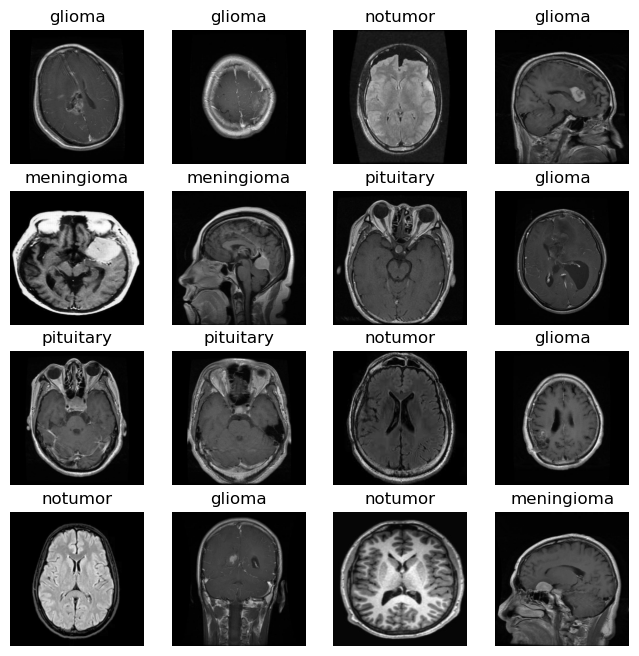

In [8]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(10):
    for i in range(min(16, len(images))): 
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255., cmap='gray')  
        plt.title(class_name[tf.argmax(labels[i]).numpy()])
        plt.axis("off")

plt.show()


# Data Augmentation

In [9]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.25, 0.2501)),
   RandomFlip("horizontal_and_vertical",seed=42),  # Specify a seed for reproducibility
])

In [10]:
# Define a custom preprocessing function
def process_data(image, label):
    augmented_image=augment_layers(image)
    resized_image = tf.image.resize(augmented_image, size=(image_size, image_size))
    return resized_image, label

# Apply augmentation and preprocessing to the dataset
training_dataset = (
    train_dataset.
    shuffle(1000)
    .map(partial(process_data),num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
vali_dataset=(
   val_dataset.shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)


)

In [12]:
input_tensor = next(iter(training_dataset))[0]

In [13]:
patche=tf.image.extract_patches(images=input_tensor,
                               sizes=[1,patch_size,patch_size,1],
                                strides=[1,patch_size,patch_size,1],
                                rates=[1,1,1,1],
                                 padding='VALID')
                                

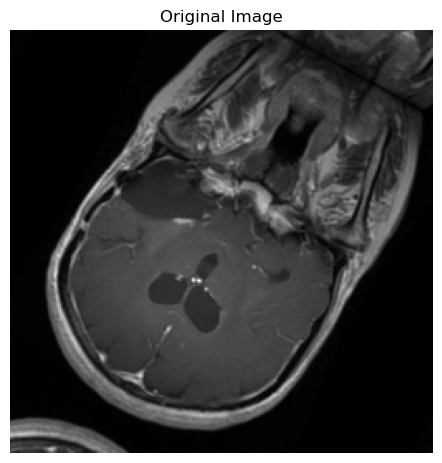

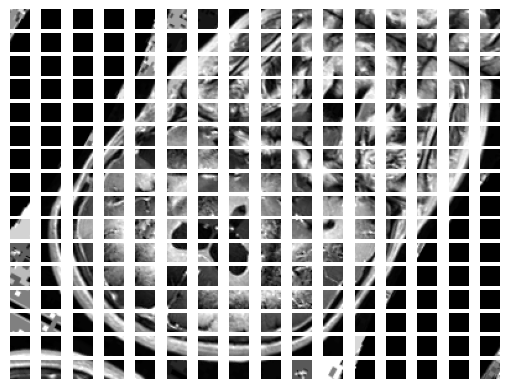

In [14]:


plt.figure(figsize=(12, 12))

batch_size, patch_rows, patch_cols, channels = patche.shape
plt.subplot(1, 2, 1)
plt.imshow(input_tensor[0],cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()
for i in range(patch_rows):
    for j in range(patch_cols):
        ax = plt.subplot(patch_rows, patch_cols, i * patch_cols + j + 1)
        plt.imshow(patche[0, i, j, :].numpy().reshape (patch_size,patch_size, 1),cmap='gray')
        plt.axis("off")

plt.show()


# VIT MODEL

In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size,Hidden_size):
        super(PatchEncoder, self).__init__(name='patch_encoder')
        self.linear_projection=Dense(Hidden_size)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=Hidden_size
        )
        
        self.num_patches=num_patches

    def call(self, image):
        batch_size = tf.shape(image)[0]  # Retrieve batch size
        patches=tf.image.extract_patches(images=image,
                                sizes=[1,patch_size,patch_size,1],
                                strides=[1,patch_size,patch_size,1],
                                rates=[1,1,1,1],
                                 padding='VALID'
                                )
       
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        embedding_input=tf.range(start=0,limit =self.num_patches,delta=1)
        output=self.linear_projection(patches)+ self.position_embedding(embedding_input)
        return output

In [16]:
class TransformerEncoder(layers.Layer):
    def __init__(self, Num_heads,Hidden_size):
        super(TransformerEncoder, self).__init__(name='transformer_encoder')
        self.layer_norm_1=LayerNormalization()
        self.layer_norm_2=LayerNormalization()
        
        self.multi_head_att=MultiHeadAttention(Num_heads,Hidden_size)
        
        self.dense_1=Dense(Hidden_size,activation=tf.nn.gelu)
        self.dense_2=Dense(Hidden_size,activation=tf.nn.gelu)


    def call(self, input):
        x=self.layer_norm_1(input)
        x1=self.multi_head_att(x,x)
        
        x1=Add()([x1,input])
        x2=self.layer_norm_2(x1)
        x2=self.dense_1(x2)
        output=self.dense_1(x2)
        output=Add()([output,x1])
      
        return output

In [17]:
class VIT(tf.keras.Model):
    def __init__(self, Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units):
        super(VIT, self).__init__(name='vision_transformer')
        self.num_layers = num_layers
        self.patch_encoder = PatchEncoder(patch_size, Hidden_size)
        self.trans_encoder = [TransformerEncoder(Num_heads, Hidden_size) for _ in range(num_layers)]
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_2 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_3 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.patch_encoder(inputs)  # Get encoded patches
        for i in range(self.num_layers):
            x = self.trans_encoder[i](x)  # Apply transformer encoder layers
        
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        output = self.dense_3(x)
        return output

# Create and compile the VIT model
vit = VIT(Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units)


# Model Training

In [19]:
loss_funcion=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,

)

In [20]:
metrics=[CategoricalAccuracy(name= 'accuracy'),TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]

In [21]:
vit.compile(
    optimizer=Adam(learning_rate=learning_rate),
                   loss=loss_funcion,
                   metrics=metrics

)

In [22]:
checkpoint_filepath = "/kaggle/working/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

In [24]:
# Train the model
history = vit.fit(
    training_dataset,
    epochs=num_epochs,
    verbose=1,
    validation_data=vali_dataset,
    callbacks=[checkpoint_callback]
    
)

Epoch 1/120
143/143 [==============================] - 34s 218ms/step - loss: 31.0535 - accuracy: 0.4208 - top_k_accuracy: 0.7236 - val_loss: 7.4288 - val_accuracy: 0.4746 - val_top_k_accuracy: 0.7592
Epoch 2/120
143/143 [==============================] - 31s 198ms/step - loss: 6.1413 - accuracy: 0.5190 - top_k_accuracy: 0.7912 - val_loss: 4.4827 - val_accuracy: 0.6077 - val_top_k_accuracy: 0.8012
Epoch 3/120
143/143 [==============================] - 30s 190ms/step - loss: 3.6239 - accuracy: 0.5838 - top_k_accuracy: 0.8315 - val_loss: 2.6529 - val_accuracy: 0.6068 - val_top_k_accuracy: 0.8284
Epoch 4/120
143/143 [==============================] - 30s 189ms/step - loss: 2.8742 - accuracy: 0.6039 - top_k_accuracy: 0.8409 - val_loss: 2.3354 - val_accuracy: 0.5928 - val_top_k_accuracy: 0.8581
Epoch 5/120
143/143 [==============================] - 32s 200ms/step - loss: 2.2697 - accuracy: 0.6247 - top_k_accuracy: 0.8591 - val_loss: 2.0805 - val_accuracy: 0.6278 - val_top_k_accuracy: 0.8441

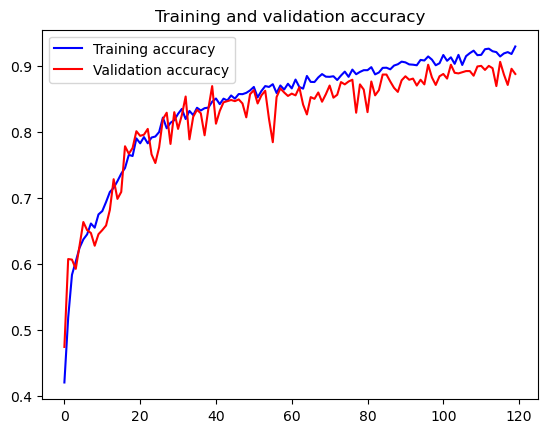

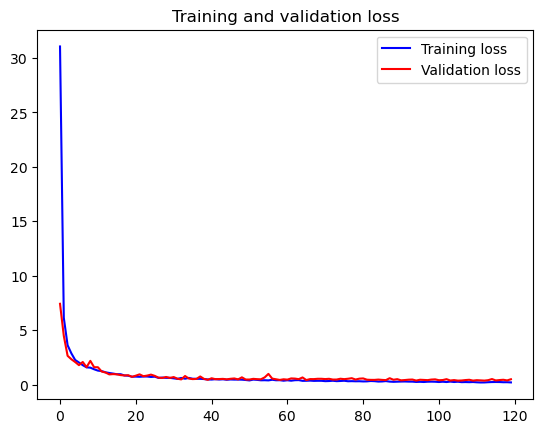

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# Saving Model

In [26]:
vit.save('/kaggle/working/')

In [27]:
vit.save_weights('/kaggle/working/')

# Prediction

In [28]:
pred = vit.predict(test_dataset)

41/41 [==============================] - 6s 75ms/step


In [29]:
vit.evaluate(test_dataset)

41/41 [==============================] - 3s 74ms/step - loss: 0.5758 - accuracy: 0.8688 - top_k_accuracy: 0.9847


[0.5758023262023926, 0.8688024282455444, 0.9847444891929626]

In [30]:
predicted=[]
labels=[]
for im, label in test_dataset:
    predicted.append(vit(im))
    labels.append(label.numpy())

In [31]:
pred= np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()])
lab= np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])

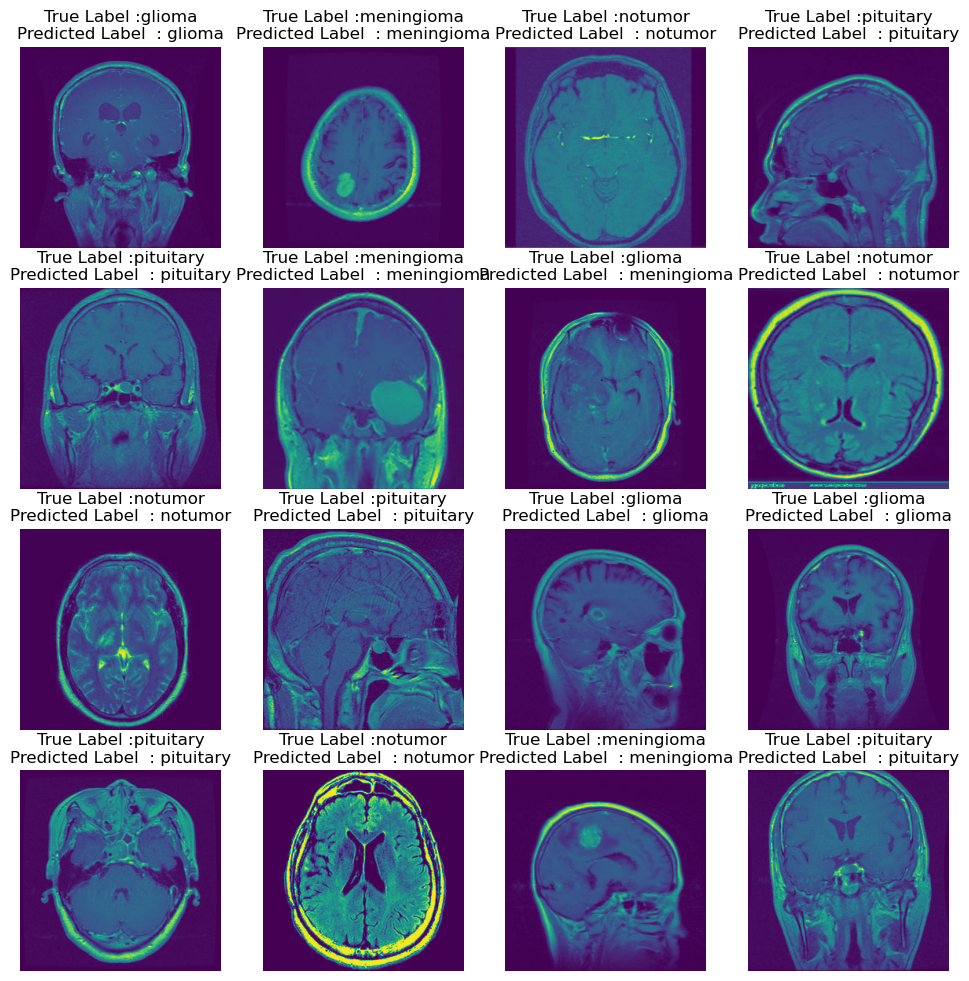

In [32]:
plt.figure(figsize=(12,12))
for   images,labels in  test_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)

   plt.imshow(images[i]/255.)
   plt.title("True Label :"+ class_name[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "Predicted Label  : " + class_name[tf.argmax(vit(tf.expand_dims(images[i],axis=0)),axis= -1).numpy()[0]])
   plt.axis("off")

# Confusion Metrics

In [ ]:
cm=confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel("Predicted")

#                                     Thank You!